https://github.com/fastai/imagenet-fast/tree/master/cifar10/dawn_submission

In [14]:
from fastai.conv_learner import *
from models.wideresnet import wrn_22 # this is the models directory from the fastai/imagenet-fast repo
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10")

In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

We construct the data object manually from low level components in a way that can be used with the fastai library.

In [16]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

In [17]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz=32
    return data

In [18]:
def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

In [19]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

## fastai DAWN bench submission 

This I believe is the original FastAI DAWN bench submission in terms of the architecture and the training parameters.

epoch      trn_loss   val_loss   accuracy                 
    0      2.534836   91181845.76 0.1       



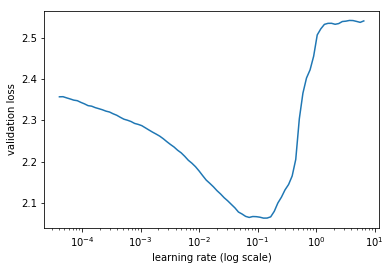

In [20]:
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4)
learn.clip = 1e-1
learn.sched.plot(n_skip_end=1)

In [21]:
%time learn.fit(1.5, 1, wds=1e-4, cycle_len=30, use_clr_beta=(15, 10, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                 
    0      1.590466   1.704077   0.4363    
    1      1.176512   1.338097   0.5637                   
    2      0.894621   1.369683   0.5694                    
    3      0.729177   0.940996   0.6916                    
    4      0.632027   1.480722   0.5686                    
    5      0.559526   0.78468    0.7331                    
    6      0.507293   0.980262   0.6995                    
    7      0.471345   0.982947   0.6977                    
    8      0.441546   0.751049   0.747                     
    9      0.407586   0.587494   0.8047                    
    10     0.389594   0.857019   0.7189                    
    11     0.365624   0.625179   0.7945                    
    12     0.348879   0.546938   0.8136                    
    13     0.325045   0.536361   0.8288                    
    14     0.310663   0.74565    0.7649                    
    15     0.288375   0.442414   0.8526                   

[array([0.19669]), 0.940800000667572]

In [22]:
get_TTA_accuracy(learn)

0.9462

In [23]:
learn.save('dawnbench_submission')

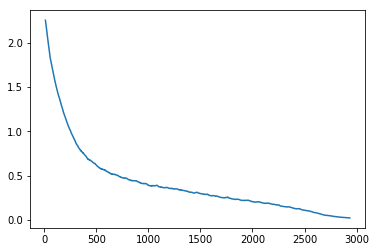

In [34]:
learn.sched.plot_loss()

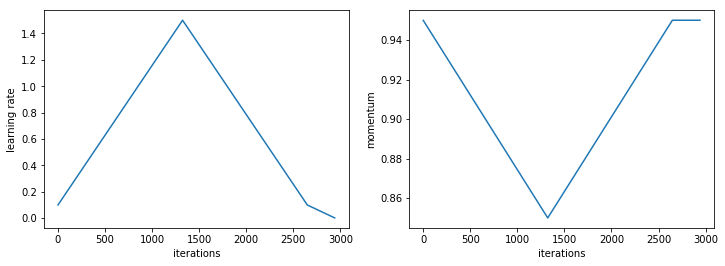

In [35]:
learn.sched.plot_lr()

## With tweaks for training on AWS p2.xlarge K80 GPU

I run the training 2 times just to make sure we hit 94% accuracy with some degree of reliability.

In [36]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.189623   1.517482   0.4644    
    1      0.875265   1.49094    0.5311                      
    2      0.732893   1.35434    0.5618                      
    3      0.69091    0.793401   0.7396                      
    4      0.622699   0.948218   0.6839                      
    5      0.592815   1.067725   0.6632                      
    6      0.538492   0.961771   0.6918                      
    7      0.537076   0.76233    0.7477                      
    8      0.500177   1.641385   0.5568                      
    9      0.501558   0.600852   0.794                       
    10     0.46636    0.672684   0.7725                      
    11     0.455601   0.632738   0.7925                      
    12     0.425208   0.74661    0.7516                      
    13     0.411003   0.475886   0.8414                      
    14     0.364351   0.49846    0.837                       
    15     0.317168   0.373

In [37]:
get_TTA_accuracy(learn)

0.9431

In [38]:
learn.save('fastest_cifar10_train_aws_p2_xlarge_01')

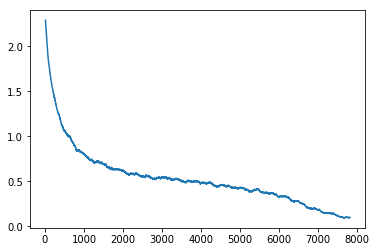

In [39]:
learn.sched.plot_loss()

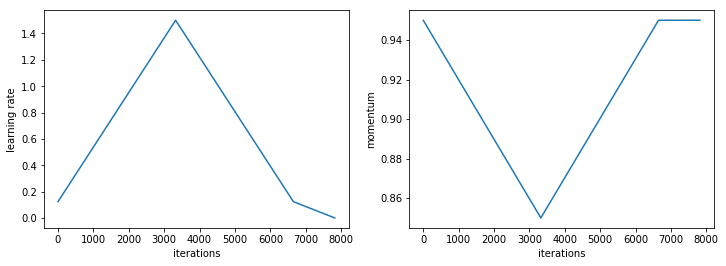

In [40]:
learn.sched.plot_lr()

In [ ]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.179364   1.354379   0.5246    
    1      0.897723   1.118864   0.6345                      
    2      0.76159    0.988467   0.6632                      
    3      0.69736    0.971793   0.677                       
    4      0.623524   0.925901   0.6932                      
    5      0.597808   1.001667   0.6742                      
    6      0.547749   1.001751   0.6732                      
    7      0.549147   0.729025   0.7503                      
    8      0.523277   0.916656   0.7167                      
    9      0.481552   0.670802   0.7727                      
    10     0.4766     0.917788   0.7252                      
    11     0.451561   0.743386   0.7615                      
    12     0.449983   0.553793   0.8122                      
    13     0.40108    0.821378   0.747                       
    14     0.386724   0.51984    0.8241                      
    15     0.324623   0.764

In [42]:
get_TTA_accuracy(learn)

0.9389

In [43]:
learn.save('fastest_cifar10_train_aws_p2_xlarge_02')

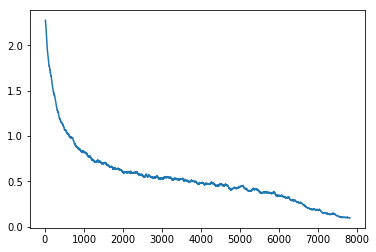

In [44]:
learn.sched.plot_loss()